In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from scipy.sparse import csr_matrix
import itertools
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
import nltk
nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df=pd.read_json("../data/musique/musique_ans_v1.0_train.jsonl", lines=True)

In [20]:
def get_titles(lst):
    # Titles where is_supporting is True
    supporting = [d['paragraph_text'] for d in lst if d.get('is_supporting') == True]
    # Titles where is_supporting is False or missing AND not already in supporting
    others = [d['paragraph_text'] for d in lst if d.get('is_supporting') != True and d['paragraph_text'] not in supporting]
    # Combine: all supporting + as many others as needed to reach 10
    result = supporting + others
    return result[:10]

df.paragraphs=df.paragraphs.apply(get_titles)

In [ ]:
# df['Sentences'] = df['paragraphs'].apply(
#     lambda para_list: [sent for para in para_list for sent in nltk.sent_tokenize(para)]
# )

In [ ]:
# df_save=pd.read_csv('../data/musique/sen_labeled.csv',
#     quotechar='"',
#     skipinitialspace=True,
#     engine='python' )

In [21]:
df["paragraphs"] = df["paragraphs"].apply(lambda p: p[:5]+ [p[1]] + p[5:])

In [22]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [ ]:
num_questions_to_run=3
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]
extras=[]
# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1,5]

for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    # gt=ast.literal_eval(df_save.labels[i])
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs=df.paragraphs[i]
    utility_cache_base_dir = f"../Experiment_data/musique/{model_path.split('/')[1]}/duplicate"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    
    # res = evaluate(df.question[i], harness.target_response, df.answer[i])
    # if res=="True":
    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map = {"S": 32, "M":128, "L":256, "XL":512}

        # Store FM models for later R²/MSE
        fm_models = {}

        for size_key, num_s in m_samples_map.items():
            if 2 ** len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2 ** len(docs) - 1 if 2 ** len(docs) > 0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0:
                methods_results[f"ContextCite{actual_samples}"], model_cc = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )

                # attributions, interactions = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                # methods_results[f"FBII{actual_samples}"] = attributions['fbii']
                # methods_results[f"Spex{actual_samples}"] = attributions['fourier']
                # methods_results[f"FSII{actual_samples}"] = attributions['fsii']

                # methods_results[f"FM_WeightsDU{actual_samples}"], Fdu, modelfmdu = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="uniform",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsDK{actual_samples}"], Fdk, modelfmdk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsLK{actual_samples}"], Flk, modelfmlk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap", sur_type="fm"
                # )
                methods_results[f"FM_WeightsLU5_{actual_samples}"], Flu5, modelfmlu5 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=5
                )
                methods_results[f"FM_WeightsLU4_{actual_samples}"], Flu4, modelfmlu4 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=4
                )
                methods_results[f"FM_WeightsLU3_{actual_samples}"], Flu3, modelfmlu3 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=3
                )
                methods_results[f"FM_WeightsLU2_{actual_samples}"], Flu2, modelfmlu2 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=2
                )
                methods_results[f"FM_WeightsLU1_{actual_samples}"], Flu1, modelfmlu1 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=1
                )
                methods_results[f"FM_WeightsLU0_{actual_samples}"], Flu0, modelfmlu0 = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm", rank=0
                )
                # Save FM models
                fm_models.update({
        
                    f"FM_WeightsLU4_{actual_samples}": modelfmlu4,
                    f"FM_WeightsLU5_{actual_samples}": modelfmlu5,
                    f"FM_WeightsLU3_{actual_samples}": modelfmlu3,
                    f"FM_WeightsLU2_{actual_samples}": modelfmlu2,
                    f"FM_WeightsLU1_{actual_samples}": modelfmlu1,
                    f"FM_WeightsLU0{actual_samples}": modelfmlu0
                })

                # Save extra Fs
                extra_results.update({
                    # "Fdu": Fdu,
                    # "Fdk": Fdk,
                    # "Flk": Flk,
                    f"Flu4_{actual_samples}": Flu4,
                    f"Flu5_{actual_samples}": Flu5,
                    f"Flu3_{actual_samples}": Flu3,
                    f"Flu2_{actual_samples}": Flu2,
                    f"Flu1_{actual_samples}": Flu1,
                    f"Flu0_{actual_samples}": Flu0,
                    # "Int_FSII":interactions['fsii'],
                    # "Int_FBII":interactions['fbii'],
                    # "Int_Spex":interactions['fourier']
                })

        methods_results["LOO"] = harness.compute_loo()
        methods_results["ARC-JSD"] = harness.compute_arc_jsd()

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="probability", models=fm_models
        )

        # R² and MSE for ContextCite
        try:
            r2, mse = harness.r2_mse(30, 'logit-prob', model_cc, method='cc')
            metrics_results["R2_cc"] = r2
            metrics_results["MSE_cc"] = mse
        except Exception: pass

        # R² and MSE for each FM method that has a model
        for method_name, fm_model in fm_models.items():
            r2, mse = harness.r2_mse(30, 'logit-prob', fm_model, method='fm')
            metrics_results[f"R2_{method_name}"] = r2
            metrics_results[f"MSE_{method_name}"] = mse

        # LDS per method
        LDS = {}
        for method_name, scores in methods_results.items():
            if "FM_WeightsLU" in method_name:
                LDS[method_name] = harness.lds(scores, 30, utl=True, model=fm_models[method_name])
            # if "FM_WeightsLK" in method_name:
            #     LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlk)
            else:
                LDS[method_name] = harness.lds(scores, 30)
        metrics_results["LDS"] = LDS

        # Precision per method
        # precision_scores = {}
        # gtset_k = get_gtset_k()
        # for method_name, scores in methods_results.items():
        #     precision_scores[method_name] = harness.precision(gtset_k, scores)
        # metrics_results["precision"] = precision_scores

        harness.save_utility_cache(current_utility_path)

        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": df.answer[i],
            "response": harness.target_response,
            "methods": methods_results,
            "metrics": metrics_results
        })
        extras.append(extra_results)

  0%|          | 0/3 [00:00<?, ?it/s]


--- Question 1/3: When was the institute that owned The Collegian founded?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx0.pkl...
Successfully loaded 1492 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 32/32 [00:00<00:00, 229432.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Computing utilities for ContextCite: 100%|██████████| 128/128 [00:00<00:00, 192426.85it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Computing utilities for ContextCite: 100%|██████████| 256/256 [00:00<00:00, 298178.79it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Computing utilities for ContextCite: 100%|██████████| 512/512 [00:00<00:00, 550495.68it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


  0%|          | 0/3 [00:08<?, ?it/s]


TypeError: ContextAttribution.evaluate_topk_performance() got an unexpected keyword argument 'utility_type'

In [9]:

with open(f"../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/results.pkl", "rb") as f:
    all_results = pickle.load(f)

In [10]:
with open(f"../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/extras.pkl", "rb") as f:
    extras = pickle.load(f)

In [45]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3,4,5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        
    }

    for res in all_results:
        metrics = res["metrics"]


        # LDS and R2
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        for method_name, lds_val in metrics["R2"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["R2"].append(lds_val)
        # Top-k
        for method_name, k_dict in metrics["topk_probability"].items():
            method = method_name_map.get(method_name, method_name)
            for k in k_values:
                if k in k_dict:
                    col_name = f"topk_probability_k{k}"
                    table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    # Standard deviations for LDS, R², and MSE
    for method, metric_dict in table_data.items():
        for metric in ["LDS", "R2"]:
            if metric in metric_dict:
                avg_table[method][f"{metric}_std"] = np.nanstd(metric_dict[metric])

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


/tmp/ipykernel_2767445/2845139303.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
/tmp/ipykernel_2767445/2845139303.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))


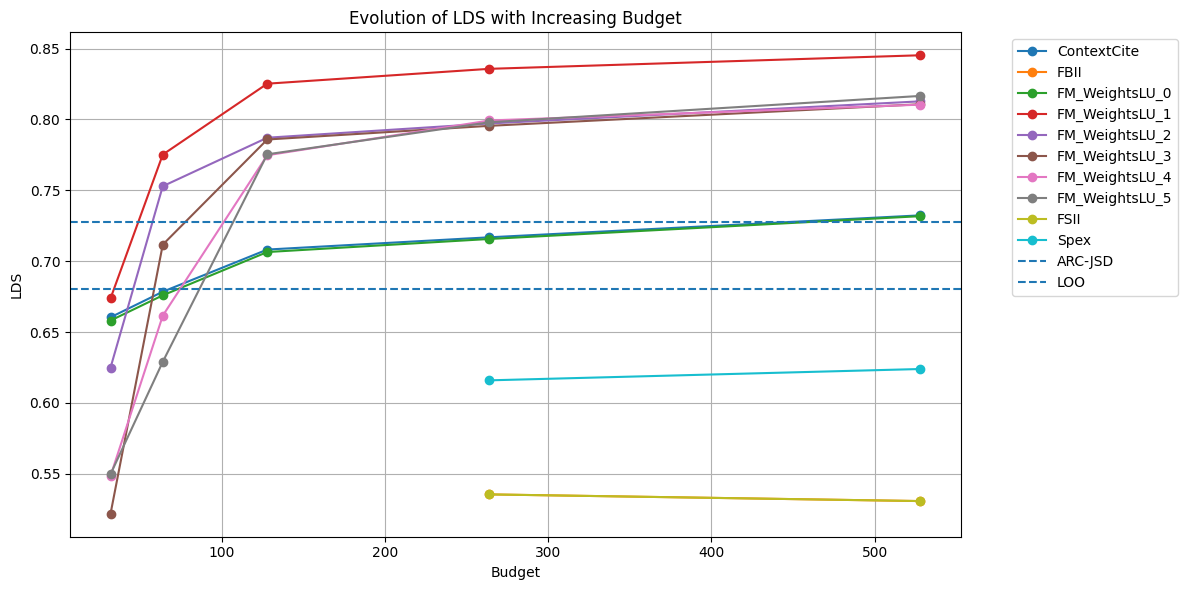

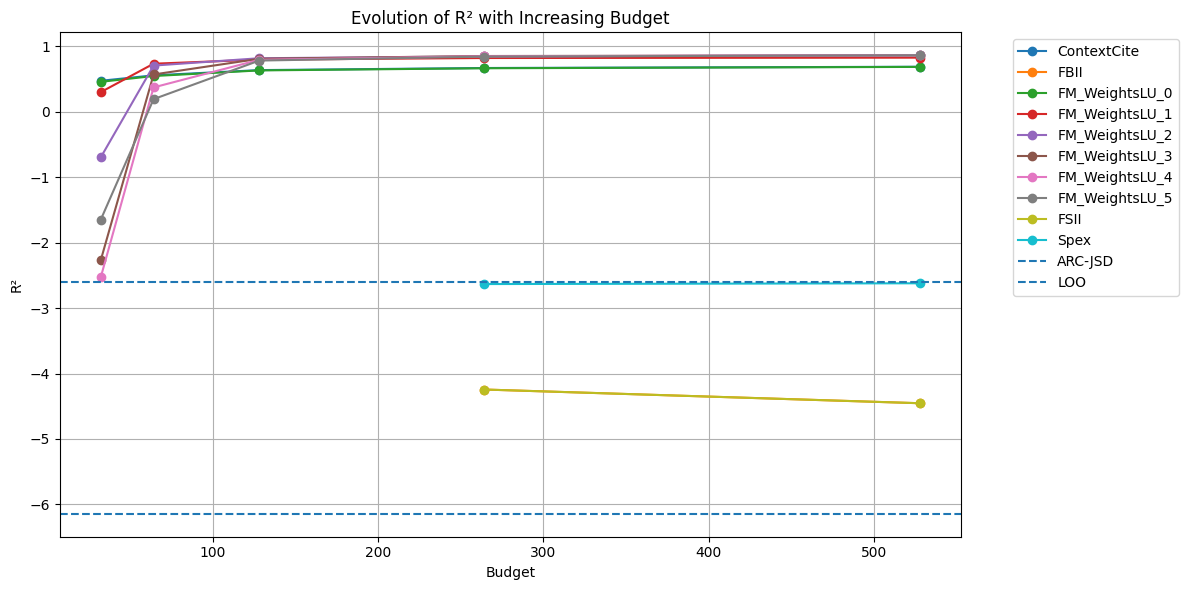

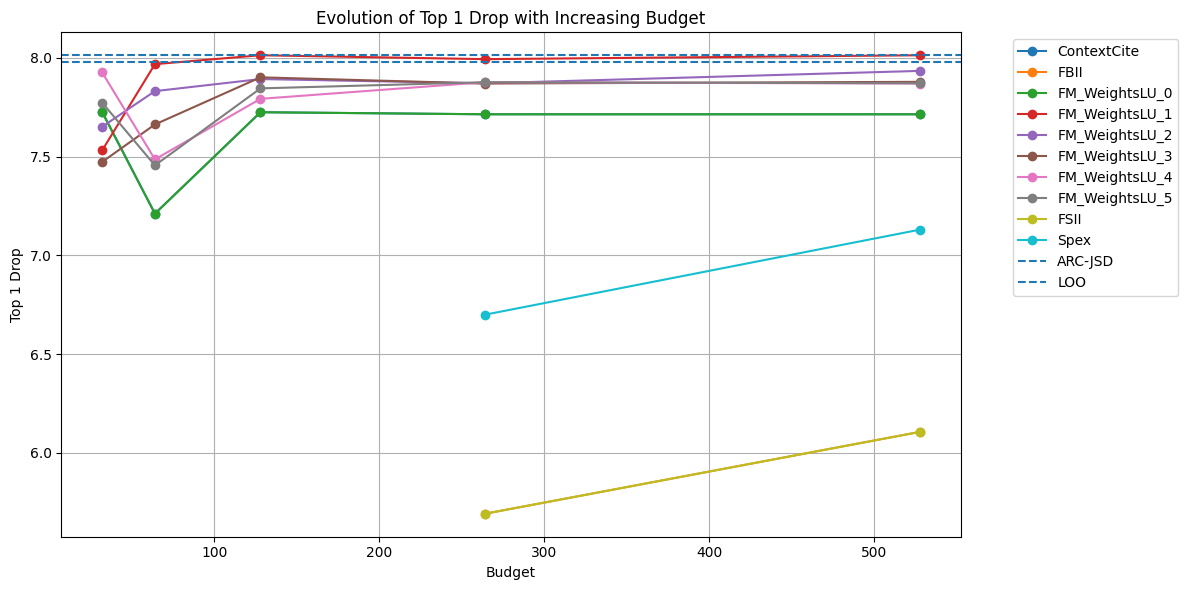

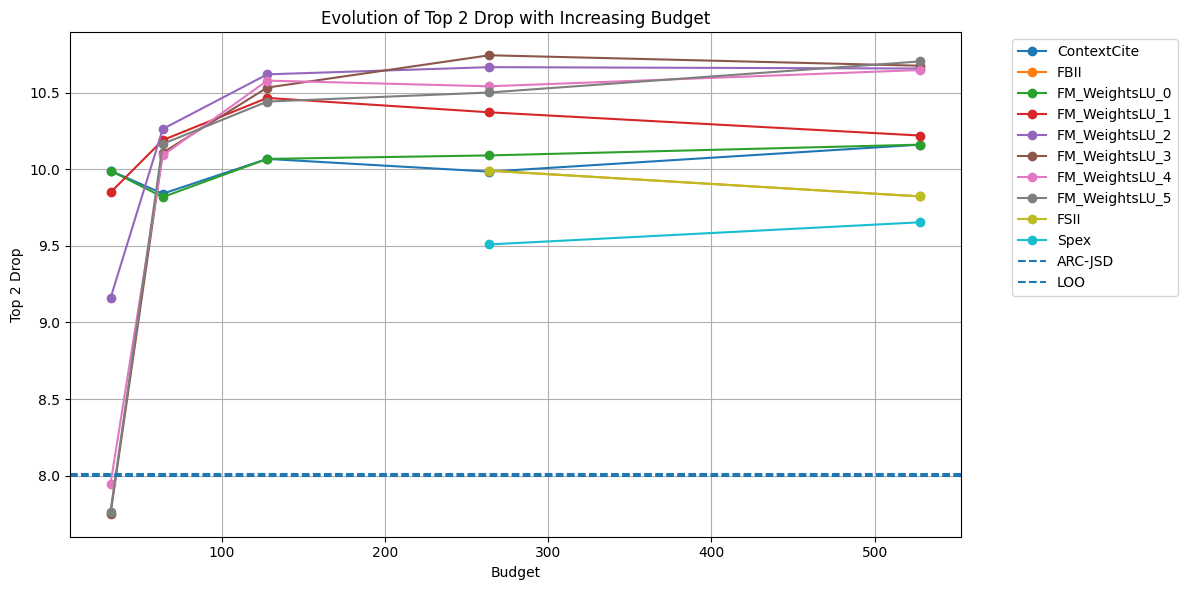

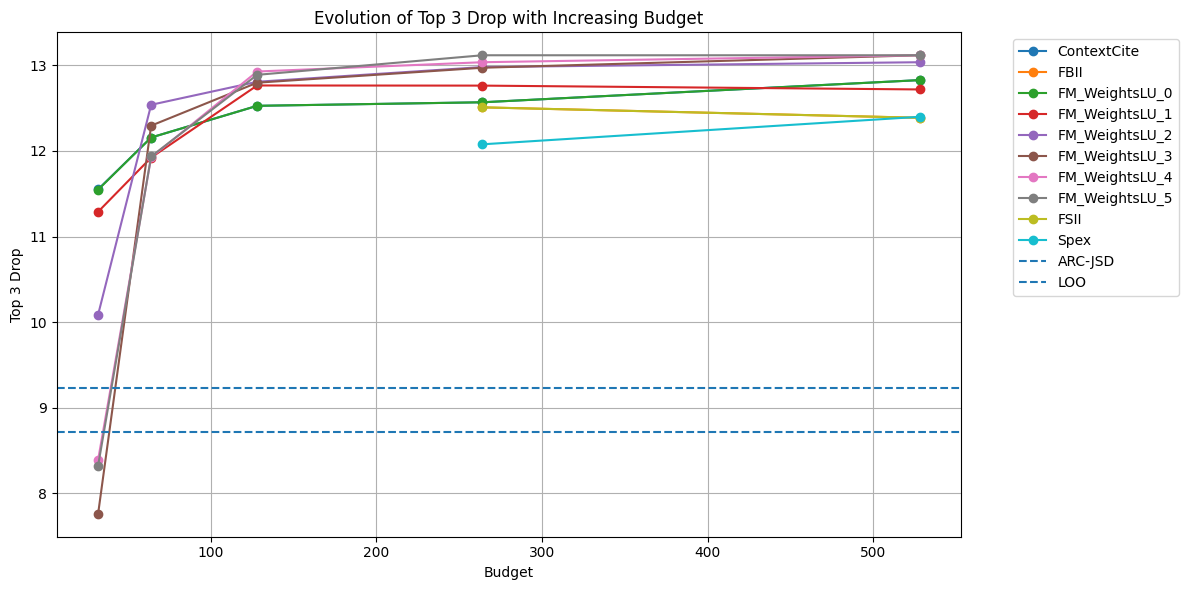

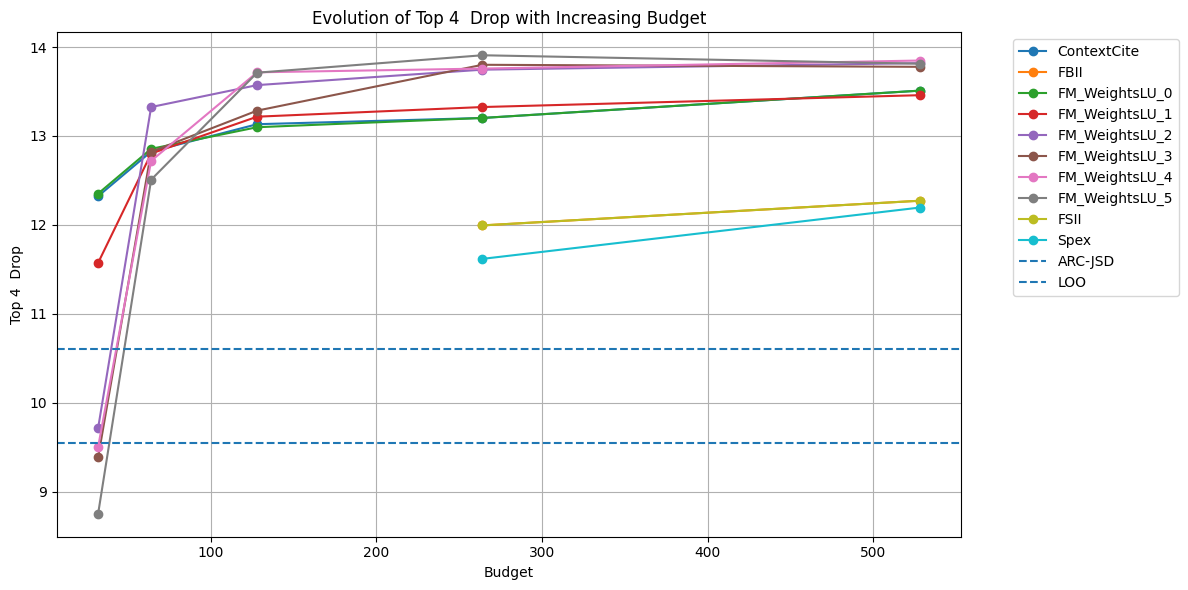

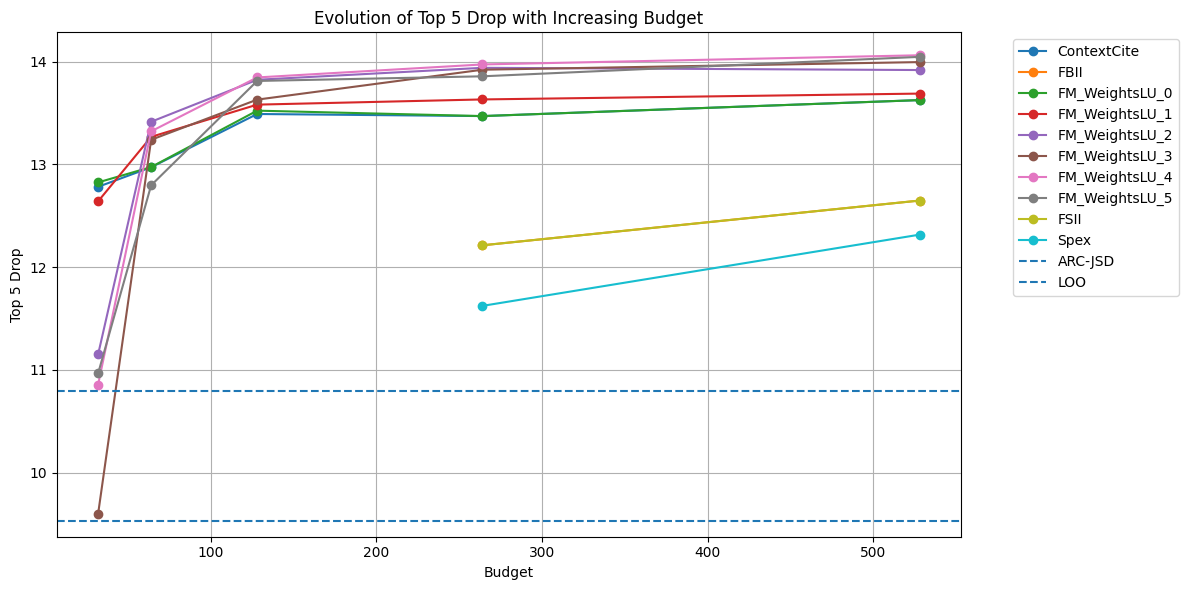

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Separate constant methods (no budget) and budgeted methods
constant_methods = ['LOO', 'ARC-JSD']
df_const = df_reset[df_reset['method'].isin(constant_methods)]
df_budgeted = df_reset[~df_reset['method'].isin(constant_methods)]

# Extract family and budget for budgeted methods
df_budgeted['family'] = df_budgeted['method'].apply(lambda x: "_".join(x.split("_")[:-1]))
df_budgeted['budget'] = df_budgeted['method'].apply(lambda x: int(x.split("_")[-1]))
df_budgeted = df_budgeted.sort_values(by=['family', 'budget'])

# Function to plot metric
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 6))

    # Plot budgeted families
    families = df_budgeted['family'].unique()
    for fam in families:
        subset = df_budgeted[df_budgeted['family'] == fam]
        plt.plot(subset['budget'], subset[metric], marker='o', label=fam)

    # Plot constant methods as horizontal lines
    for _, row in df_const.iterrows():
        plt.axhline(y=row[metric], linestyle='--', label=row['method'])

    plt.xlabel("Budget")
    plt.ylabel(ylabel)
    plt.title(f"Evolution of {ylabel} with Increasing Budget")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot LDS
plot_metric("LDS", "LDS")

# Plot R²
plot_metric("R2", "R²")

plot_metric("topk_probability_k1", "Top 1 Drop")
plot_metric("topk_probability_k2", "Top 2 Drop")
plot_metric("topk_probability_k3", "Top 3 Drop")
plot_metric("topk_probability_k4", "Top 4  Drop")
plot_metric("topk_probability_k5", "Top 5 Drop")


In [46]:
df_res=summarize_and_print(all_results, k_values=[1, 2, 3,4,5])


=== Metrics Summary Across All Queries ===
                      LDS      R2  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_probability_k4  topk_probability_k5  LDS_std  R2_std
ARC-JSD            0.6807 -2.5995               7.9811               8.0079               9.2333              10.5999              10.7997   0.2348  9.3904
ContextCite_128    0.7082  0.6351               7.7250              10.0673              12.5272              13.1324              13.4910   0.2444  0.2647
ContextCite_264    0.7169  0.6672               7.7147               9.9841              12.5686              13.2024              13.4707   0.2542  0.2515
ContextCite_32     0.6604  0.4718               7.7259               9.9902              11.5523              12.3228              12.7825   0.2380  0.4185
ContextCite_528    0.7324  0.6864               7.7147              10.1604              12.8276              13.5099              13.6264   0.2440  0.2335
ContextCite_64     0

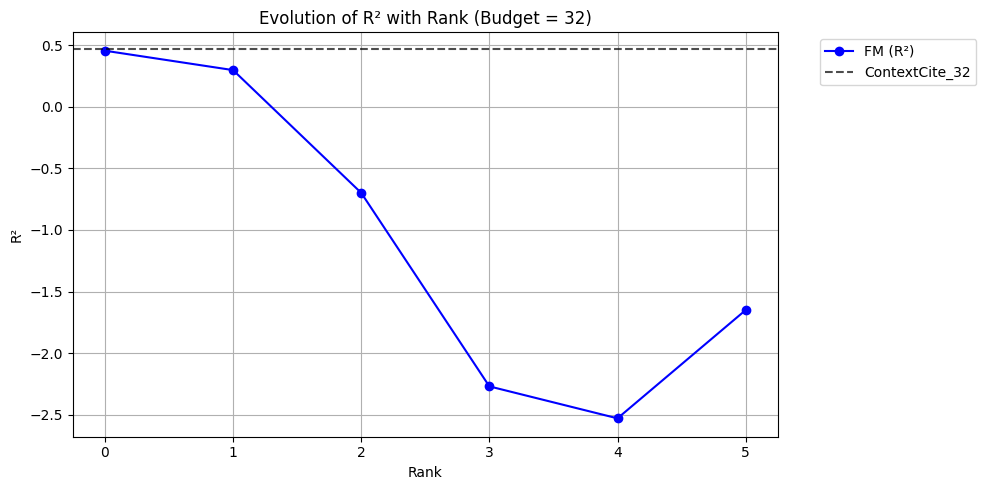

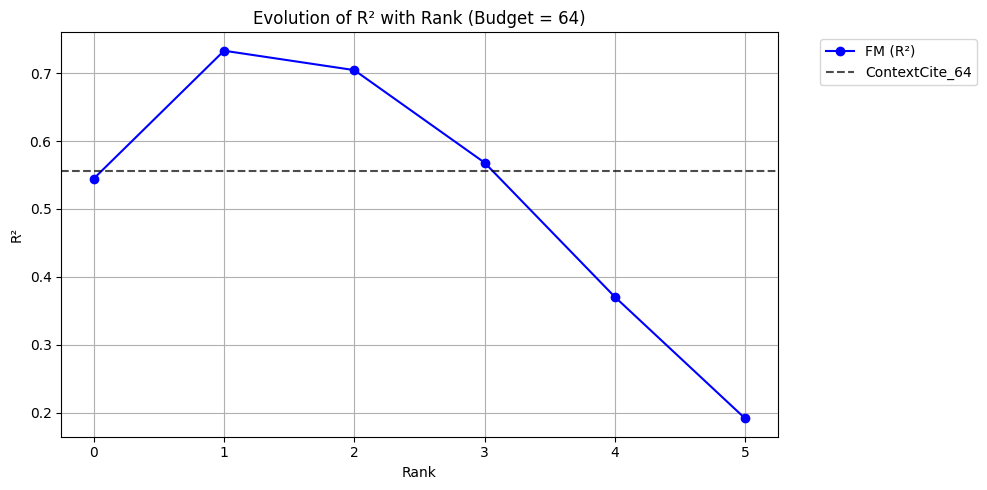

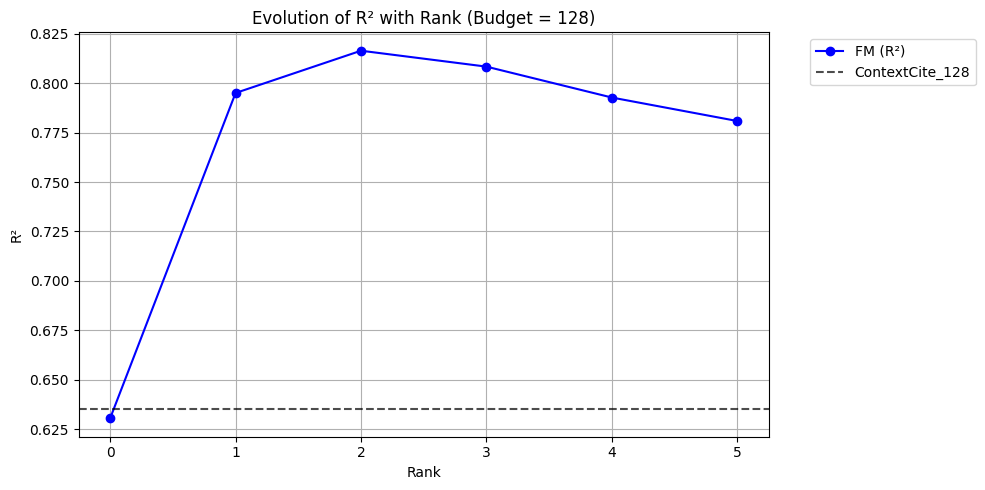

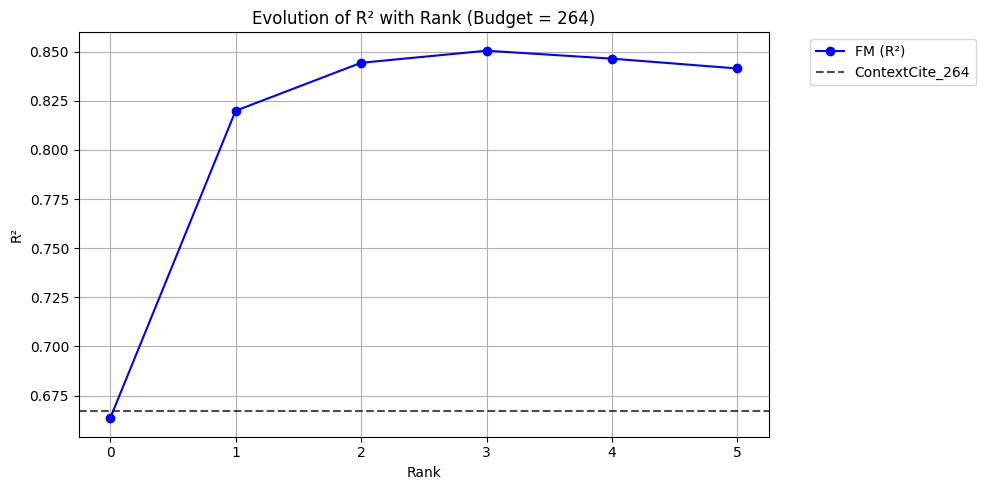

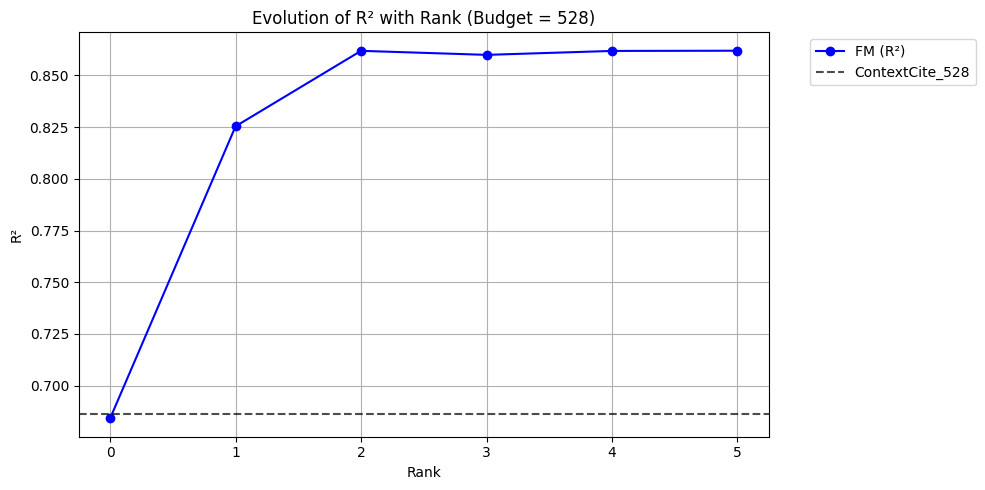

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['R2'], marker='o', color="blue", label="FM (R²)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['R2'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("R²")
    plt.title(f"Evolution of R² with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

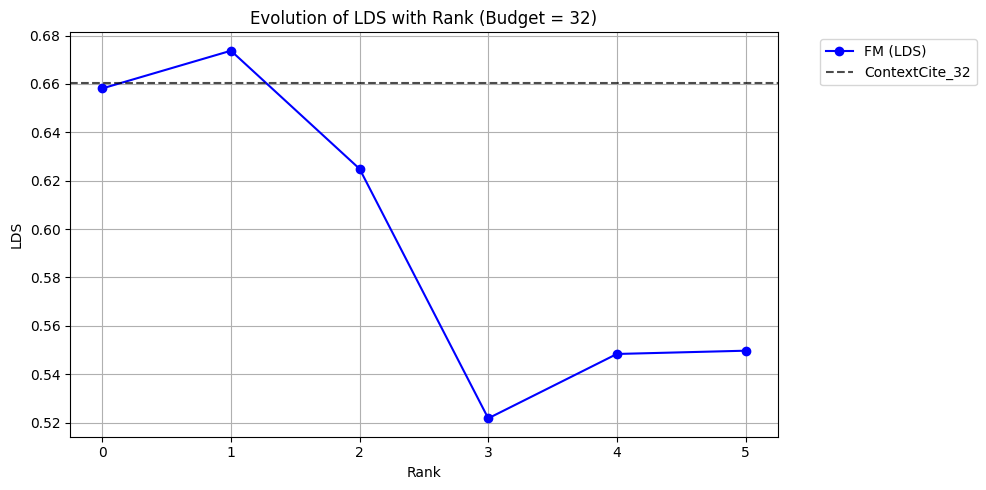

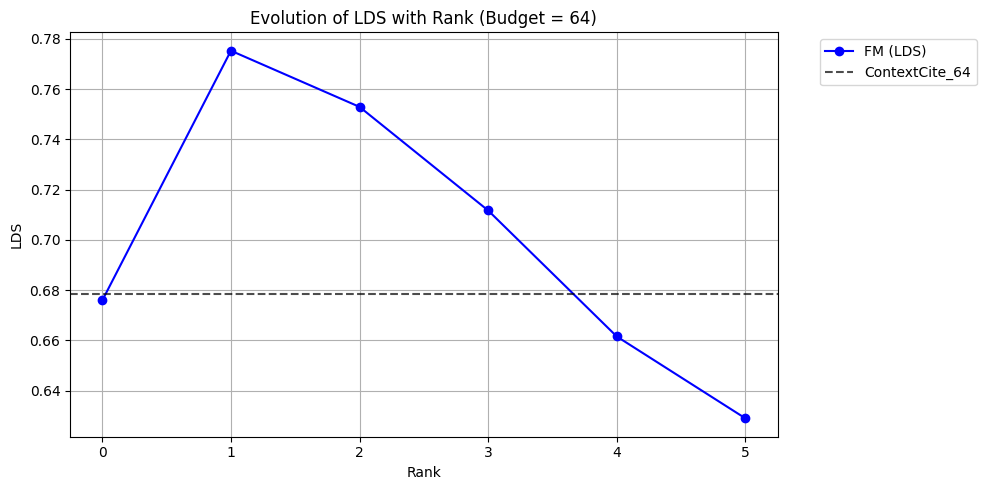

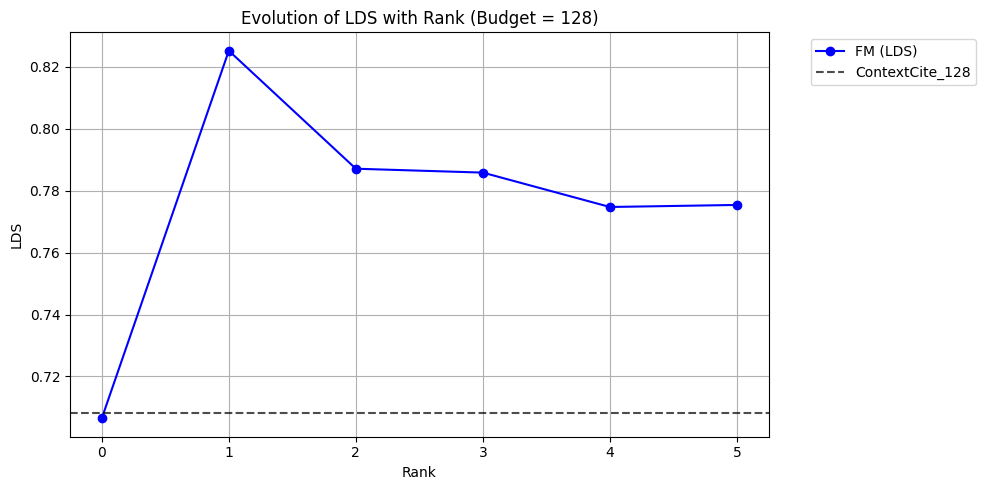

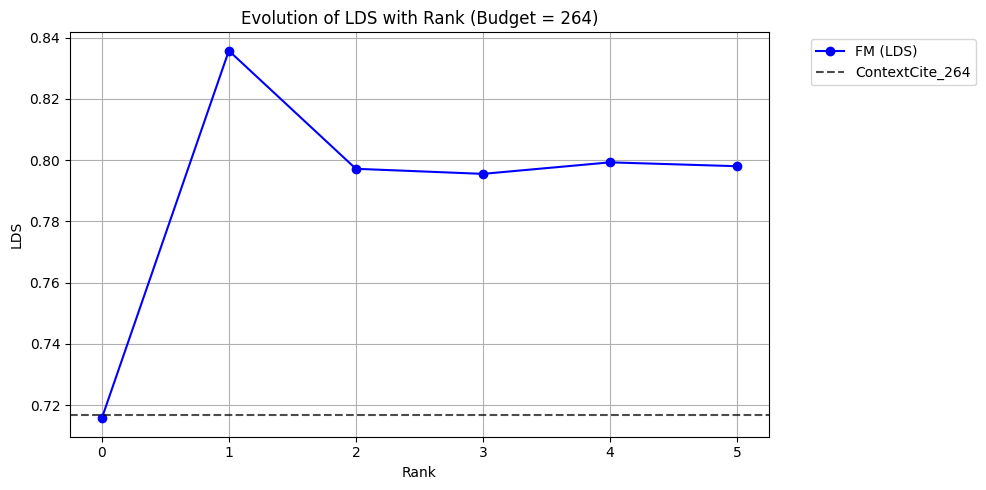

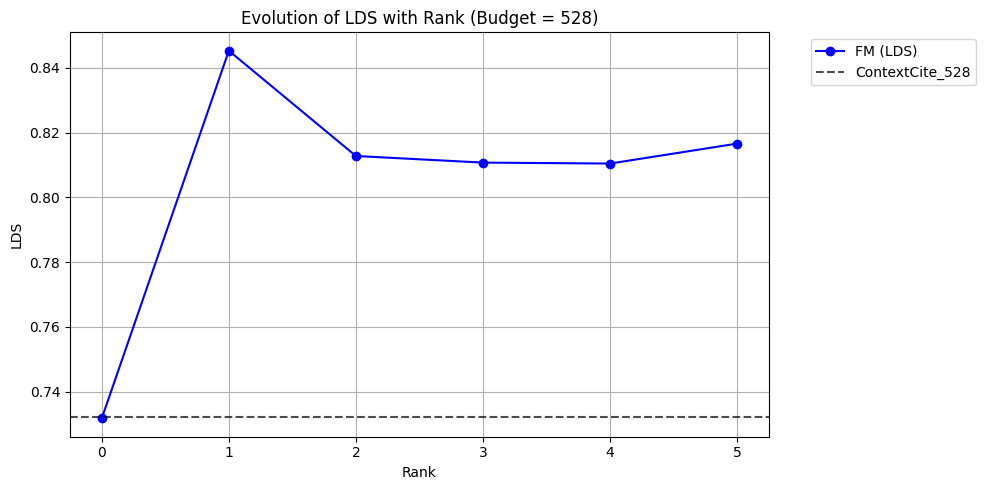

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Keep only ContextCite baselines
df_contextcite = df_nonfm[df_nonfm['method'].str.startswith("ContextCite")]

# Function to plot R² for a given budget
def plot_r2_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (R² vs rank)
    plt.plot(subset_fm['rank'], subset_fm['LDS'], marker='o', color="blue", label="FM (LDS)")

    # Plot only ContextCite baselines for this budget
    for _, row in df_contextcite.iterrows():
        if row['method'].endswith(f"_{budget}"):
            plt.axhline(y=row['LDS'], linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank")
    plt.ylabel("LDS")
    plt.title(f"Evolution of LDS with Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_r2_for_budget(32)
plot_r2_for_budget(64)
plot_r2_for_budget(128)
plot_r2_for_budget(264)
plot_r2_for_budget(528)

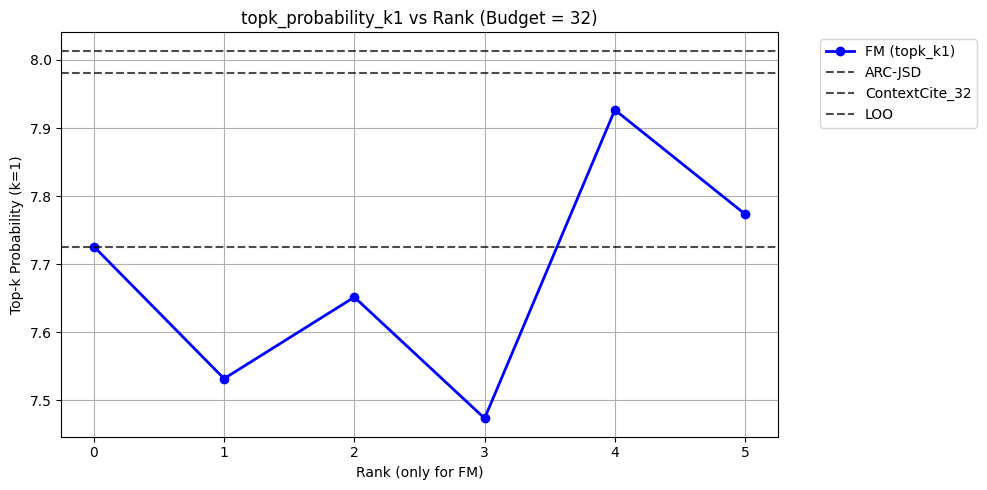

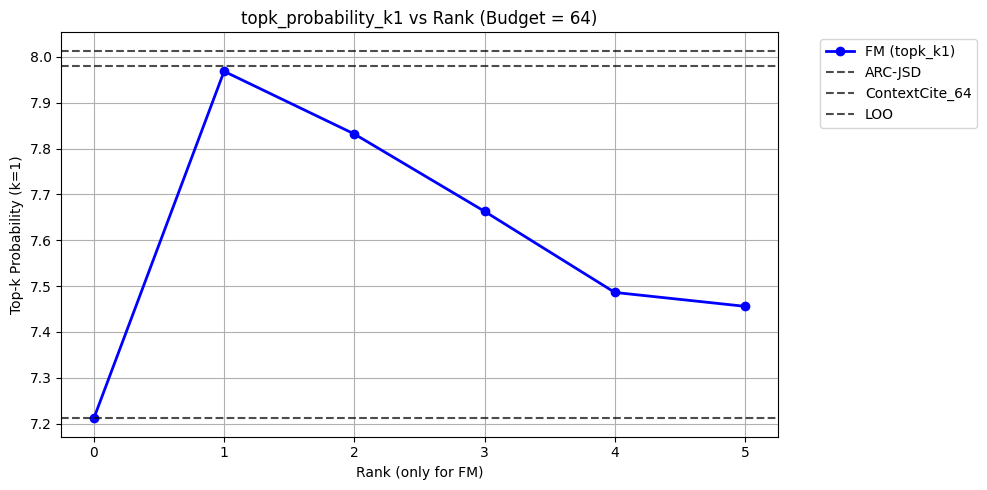

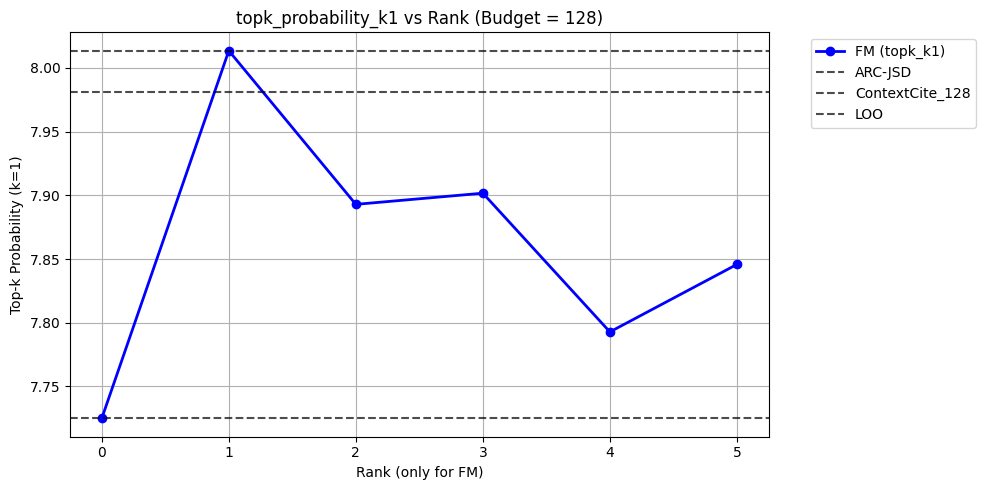

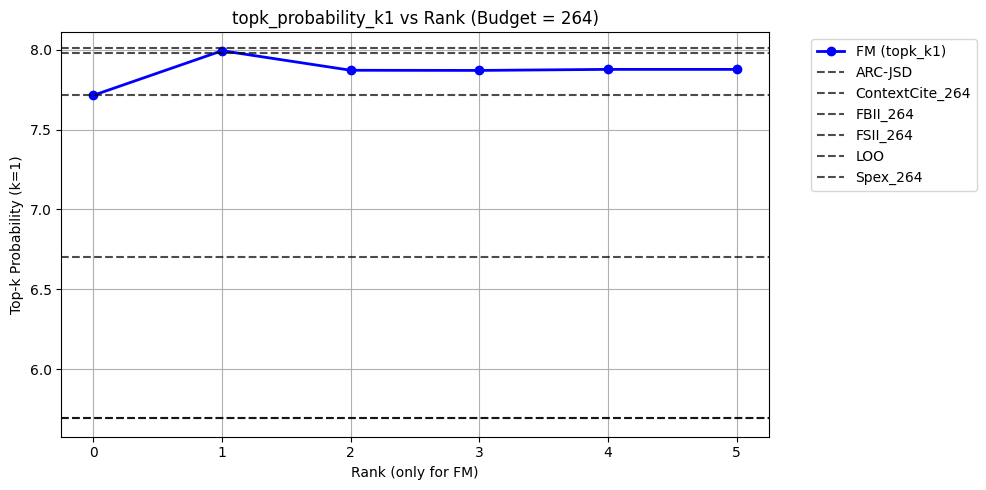

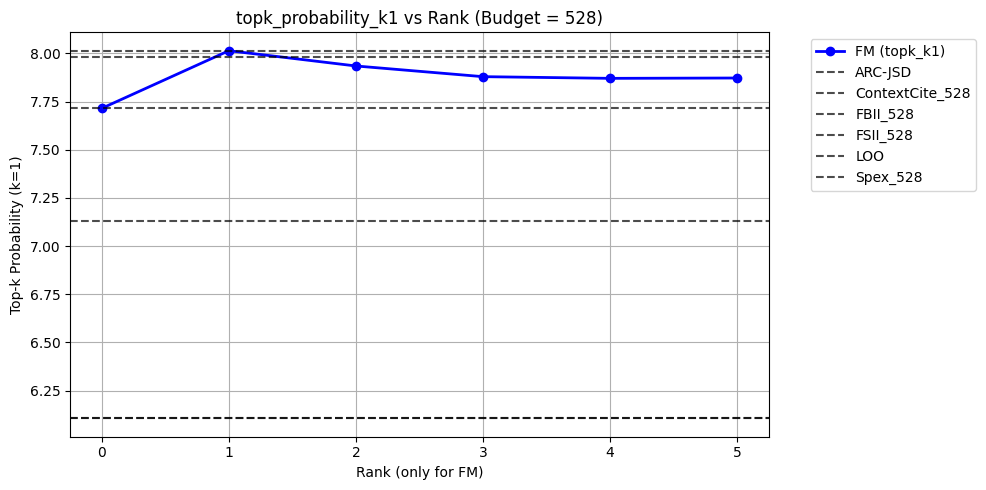

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Reset index
df_reset = df_res.reset_index().rename(columns={'index': 'method'})

# Parse FM methods (rank + budget)
def parse_fm(method):
    parts = method.split("_")
    if parts[0] == "FM" and "WeightsLU" in parts[1]:
        rank = int(parts[2])
        budget = int(parts[-1])
        return rank, budget
    return None, None

df_reset['rank'], df_reset['budget'] = zip(*df_reset['method'].apply(parse_fm))

# Separate FM and non-FM methods
df_fm = df_reset[df_reset['rank'].notnull()]
df_nonfm = df_reset[df_reset['rank'].isnull()]

# Function to plot topk_probability_k1 for a given budget
def plot_topk_for_budget(budget):
    plt.figure(figsize=(10, 5))

    # Subset FM methods for this budget
    subset_fm = df_fm[df_fm['budget'] == budget].sort_values(by='rank')

    # Plot FM evolution (vs rank)
    plt.plot(subset_fm['rank'], subset_fm['topk_probability_k1'],
             marker='o', color="blue", linewidth=2, label="FM (topk_k1)")

    # Plot all other methods as black dashed lines
    for _, row in df_nonfm.iterrows():
        if row['method'].endswith(f"_{budget}") or row['method'] in ["LOO", "ARC-JSD"]:
            plt.axhline(y=row['topk_probability_k1'],
                        linestyle='--', color="black", alpha=0.7, label=row['method'])

    plt.xlabel("Rank (only for FM)")
    plt.ylabel("Top-k Probability (k=1)")
    plt.title(f"topk_probability_k1 vs Rank (Budget = {budget})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: plot for budget = 528
plot_topk_for_budget(32)
plot_topk_for_budget(64)
plot_topk_for_budget(128)
plot_topk_for_budget(264)
plot_topk_for_budget(528)


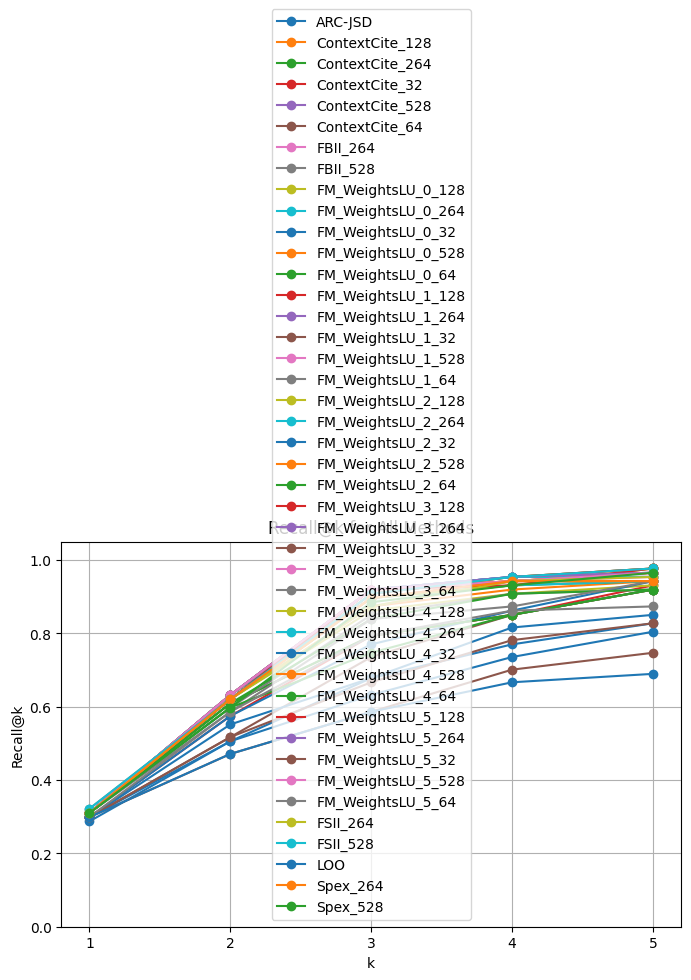

In [15]:
recall_table=compute_recall_at_k(all_results, k_values=[1, 2, 3, 4, 5])
plot_recall_at_k(recall_table, k_values=[1, 2, 3, 4, 5])

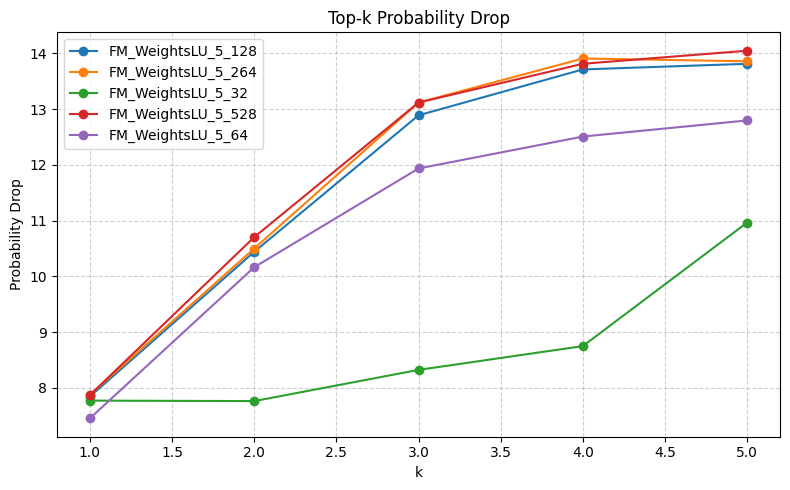

In [43]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    if "FM_WeightsLU_5" in method:
        plt.plot(
            [1, 2, 3,4,5],
            df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3', 'topk_probability_k4', 'topk_probability_k5']],
            marker='o',
            label=method
        )

plt.xlabel('k')
plt.ylabel('Probability Drop')
plt.title('Top-k Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [29]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = extras[1].keys()
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if "Flu"in method:
                # Flu is a matrix
                value = exp[method][k][m]
                all_values = exp[method].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    ones = [i for i, bit in enumerate(key) if bit == 1]
                    if set(ones) == {k, m}:
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

# Second stage

In [34]:
# Recovery rate
for i, j in enumerate(np.array(list(evaluate_methods(extras, k=0, m=1, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=0, m=5, interaction_type="max").values()))+np.array(list(evaluate_methods(extras, k=5, m=1, interaction_type="min").values()))):
    print(f"Recovery Rate of {list(extras[1].keys())[i]}={j}")

Recovery Rate of Flu_5_32=0.27586206896551724
Recovery Rate of Flu_4_32=0.1724137931034483
Recovery Rate of Flu_3_32=0.20689655172413793
Recovery Rate of Flu_2_32=0.41379310344827586
Recovery Rate of Flu_1_32=0.48275862068965514
Recovery Rate of Flu_0_32=3.0
Recovery Rate of Flu_5_64=0.7931034482758621
Recovery Rate of Flu_4_64=0.7931034482758621
Recovery Rate of Flu_3_64=0.9655172413793103
Recovery Rate of Flu_2_64=0.9655172413793103
Recovery Rate of Flu_1_64=0.6896551724137931
Recovery Rate of Flu_0_64=3.0
Recovery Rate of Flu_5_128=1.103448275862069
Recovery Rate of Flu_4_128=1.103448275862069
Recovery Rate of Flu_3_128=1.103448275862069
Recovery Rate of Flu_2_128=1.0689655172413794
Recovery Rate of Flu_1_128=0.7241379310344828
Recovery Rate of Flu_0_128=3.0
Recovery Rate of Flu_5_264=1.1379310344827585
Recovery Rate of Flu_4_264=1.103448275862069
Recovery Rate of Flu_3_264=1.103448275862069
Recovery Rate of Flu_2_264=1.0344827586206895
Recovery Rate of Flu_1_264=0.7241379310344829


In [ ]:
np.array(list(evaluate_methods(extras, k=0, m=1, interaction_type="max").values()))